In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import embedders
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

N_TRIALS = 10
N_POINTS = 1_000
N_FEATURES = "d_choose_2"
MAX_DEPTH = 5

TASK = "regression"
SCORE = ["rmse"]

X, y, _ = embedders.dataloaders.load("temperature")

pm = embedders.manifolds.ProductManifold(signature=[(1, 2), (1, 1)], device="cuda")

results = []
for seed in tqdm(range(N_TRIALS)):
    # Sample 1000 points randomly
    idx = np.random.choice(X.shape[0], N_POINTS, replace=False)
    res = embedders.benchmarks.benchmark(
        X=X[idx],
        y=y[idx],
        pm=pm,
        seed=seed,
        task="regression",
        score=["rmse"],
        device="cuda",
        lr=1e-10,
        # models=["kappa_gcn"]
        models = [
            # "sklearn_dt",
            # "sklearn_rf",
            # "product_dt",
            # "product_rf",
            # "tangent_dt",
            # "tangent_rf",
            # "knn",
            # "ps_perceptron",
            # "svm",
            # "ps_svm",
            # "tangent_mlp",
            # "ambient_mlp",
            # "tangent_gnn",
            # "ambient_gnn",
            "kappa_gcn",
            # "product_mlr",
        ],
        epochs=100
    )
    res["seed"] = seed
    results.append(res)

results = pd.DataFrame(results)
# results.to_csv("../data/results/temperature.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results.to_csv("embedders/data/results_icml/temperature.tsv", index=False, sep="\t")

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dists = pm.pdist2(X.cuda())
dists /= dists[torch.isfinite(dists)].max()
A_hat = embedders.predictors.kappa_gcn.get_A_hat(dists).detach()
A_hat.isnan().any()

pm_stereo, X_stereo = pm.stereographic(X)

kappa_gcn = embedders.predictors.kappa_gcn.KappaGCN(
    pm=pm_stereo, hidden_dims=[pm.dim, pm.dim], task="regression", output_dim=1
).cuda()

# y_pred = kappa_gcn(X_stereo_train.cuda(), A_hat.cuda())
# loss_fn = torch.nn.MSELoss()
# loss_fn(y_pred, y.cuda())

kappa_gcn.fit(X_stereo.cuda(), y.cuda(), A_hat.cuda(), lr=1e-2, epochs=1000, use_tqdm=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
pm.stereographic(X)[1].isnan().any()

tensor(False)

In [27]:
# Look at plots

import embedders.dataloaders


N_POINTS = 400
SHAPE = (N_POINTS + 1, N_POINTS // 2 + 1)


def long_lat_to_xyz(X):
    long, lat = X[:, 0], X[:, 1]
    x = torch.cos(lat) * torch.cos(long)
    y = torch.cos(lat) * torch.sin(long)
    z = torch.sin(lat)
    return torch.stack([x, y, z], dim=1)


def xyz_to_long_lat(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    long = torch.atan2(y, x)
    lat = torch.asin(z)
    return torch.stack([long, lat], dim=1)


# Get a meshgrid
_x_vals = torch.linspace(-torch.pi, torch.pi, SHAPE[0])
_y_vals = torch.linspace(-torch.pi / 2, torch.pi / 2, SHAPE[1])
_x_vals, _y_vals = torch.meshgrid(_x_vals, _y_vals)
_X = torch.stack([_x_vals.flatten(), _y_vals.flatten()], dim=1)
_X = long_lat_to_xyz(_X)

# Need to add 2 dimensions for month
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Jan")
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Apr")
jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Jul")
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Oct")
_X = torch.cat([_X, torch.tensor(jan_embedding).expand(_X.shape[0], -1)], dim=1)

# Transform data to long-lat coords
X_transformed = xyz_to_long_lat(X)

# For plotting, we'll need degrees
_x_vals_degrees = torch.rad2deg(_x_vals).numpy()
_y_vals_degrees = torch.rad2deg(_y_vals).numpy()

In [28]:
# Get predictions

pdt.batched = False
pdt.batch_size = 1
pdt_pred = []
# Predict 100 at a time to avoid memory issues
for i in range(0, len(_X), 100):
    pdt_pred.append(pdt.predict(_X[i : i + 100]).numpy())
pdt_pred = np.concatenate(pdt_pred)

/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_36145/3900894380.py:44: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x35552ba60>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_36145/3900894380.py:44: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x3556f85b0>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_36145/3900894380.py:44: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x3556faa40>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_36145/3900894380.py:44: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x3556e9930>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_36145/3900894380.py:59: UserWarning: This figure includes Axes that are n

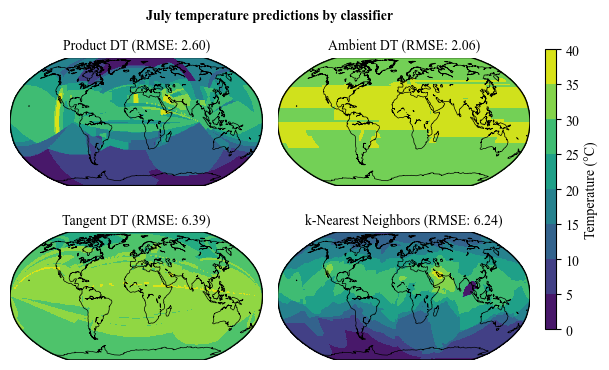

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Set font to LaTeX times font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# LEVELS = 2 ** (MAX_DEPTH) # One for each discrete prediction
LEVELS = None
FONTSIZE = 10

# Plot surface in long, lat basis
fig, axs = plt.subplots(2, 2, figsize=(5.5, 4))

# Map
m = Basemap(projection="robin", lon_0=0, resolution="c")
_x_map, _y_map = m(_x_vals_degrees, _y_vals_degrees)  # Grid

# Get city coords
city_coords = xyz_to_long_lat(X)
x_map, y_map = m(torch.rad2deg(city_coords[:, 0]).numpy(), torch.rad2deg(city_coords[:, 1]).numpy())

# Plot contours

axs[0, 0].contourf(_x_map, _y_map, pdt_pred.reshape(SHAPE), levels=LEVELS)
axs[0, 0].set_title(f"Product DT (RMSE: {pdt_score:.2f})", fontsize=FONTSIZE)
axs[0, 1].contourf(_x_map, _y_map, dt.predict(_X).reshape(SHAPE), levels=LEVELS)
axs[0, 1].set_title(f"Ambient DT (RMSE: {dt_score:.2f})", fontsize=FONTSIZE)
axs[1, 0].contourf(_x_map, _y_map, tdt.predict(pm.logmap(_X).detach().numpy()).reshape(SHAPE), levels=LEVELS)
axs[1, 0].set_title(f"Tangent DT (RMSE: {tdt_score:.2f})", fontsize=FONTSIZE)
axs[1, 1].contourf(_x_map, _y_map, knn.predict(_X).reshape(SHAPE), levels=LEVELS)
axs[1, 1].set_title(f"k-Nearest Neighbors (RMSE: {knn_score:.2f})", fontsize=FONTSIZE)

for ax in axs.flatten():
    # Ticks off
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    m.drawcoastlines(ax=ax, linewidth=0.5)
    # ax.scatter(x_map, y_map, c=y, cmap="viridis", edgecolors="black", s=9)

    # Rasterize contour plots
    for coll in ax.collections:
        coll.set_rasterized(True)

# Colorbar
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
# Colorbar with font size 20
fig.colorbar(axs[1, 1].collections[0], cax=cbar_ax, orientation="vertical", label="Temperature (°C)")
cbar_ax.tick_params(labelsize=FONTSIZE)
# Also the label should be larger
cbar_ax.yaxis.label.set_size(FONTSIZE)

# plt.suptitle("January temperature predictions by classifier", fontsize=FONTSIZE, weight="bold", position=(0.5, 0.95))
# plt.suptitle("April temperature predictions by classifier", fontsize=FONTSIZE, weight="bold", position=(0.5, 0.95))
plt.suptitle("July temperature predictions by classifier", fontsize=FONTSIZE, weight="bold", position=(0.5, 0.95))
# plt.suptitle("October temperature predictions by classifier", fontsize=FONTSIZE, weight="bold", position=(0.5, 0.95))
plt.tight_layout()
# plt.show()
# plt.savefig("../figures/temp_jan.pdf", bbox_inches="tight")
# plt.savefig("../figures/temp_apr.pdf", bbox_inches="tight")
plt.savefig("../figures/temp_jul.pdf", bbox_inches="tight")
# plt.savefig("../figures/temp_oct.pdf", bbox_inches="tight")